In [1]:
%matplotlib inline

In [2]:
import time
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext.data as data
import matplotlib.pyplot as plt

from torchtext.vocab import GloVe
from torch.autograd import Variable
from torchtext.datasets import IMDB
from vectors import MultiCCA, VectorVocabField

In [3]:
MAX_LENGTH=373
EPOCHS=10

In [4]:
vectors=GloVe(name='6B', dim=50)

In [5]:
class ConvClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, pretrained_embeddings, 
                 num_filters=100, window_sizes=(3, 4, 5), mode='static', num_classes=2):
        super(ConvClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(pretrained_embeddings)
        self.embedding.weight.requires_grad = (mode == 'nonstatic')
        
#         self.hidden = nn.Linear(embedding_dim, num_filters)
#         self.out = nn.Linear(num_filters, num_classes)

        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, [window_size, embedding_dim], padding=(window_size - 1, 0))
            for window_size in window_sizes
        ])
    
#         self.norms = nn.ModuleList([
#             nn.BatchNorm2d(num_filters) for window_size in window_sizes
#         ])

        self.norm = nn.BatchNorm1d(num_classes)

        self.fc = nn.Linear(num_filters * len(window_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x)           # [B, T, E]
#         x = x.mean(dim=1)
#         x = F.sigmoid(self.hidden(x))
#         x = F.softmax(self.out(x), dim=1)
        
#         return x
        
        # Apply a convolution + max pool layer for each window size
        x = torch.unsqueeze(x, 1)       # [B, C, T, E] Add a channel dim.
        xs = []
        for conv in self.convs:
            x2 = F.relu(conv(x))        # [B, F, T, 1]
            x2 = torch.squeeze(x2, -1)  # [B, F, T]
#             x2 = norm(x2)
            x2 = F.max_pool1d(x2, x2.size(2))  # [B, F, 1]
            xs.append(x2)
        x = torch.cat(xs, 2)            # [B, F, window]

        # FC
        x = x.view(x.size(0), -1)       # [B, F * window]
        logits = self.fc(x)             # [B, class]
        
        logits = self.norm(logits)

        # Prediction
        probs = F.softmax(logits, dim=1)       # [B, class]

        return probs

In [6]:
import string

translator = str.maketrans('', '', string.punctuation)

# allows us to generate 
def preprocess(l):
    nopunct = [s.translate(translator) for s in l]
    return [s for s in nopunct if s and s in vectors.stoi]

# needed because `split` subclasses dataset, and thus doesn't have a
# proper sort key
def sort_key(ex):
    return len(ex.text)

text_field = VectorVocabField(lower=True, preprocessing=preprocess)
#text_field = GloVeField(lower=True, preprocessing=preprocess, fix_length=MAX_LENGTH)
label_field = data.Field(sequential=False, unk_token=None, pad_token=None)

train, test = IMDB.splits(text_field=text_field, label_field=label_field)
train, val = train.split(split_ratio=0.7)
train.sort_key = sort_key
val.sort_key = sort_key

text_field.build_vocab(train, vectors=vectors)
label_field.build_vocab(train)

train, val, test = data.BucketIterator.splits(
    (train, val, test), batch_sizes=(128, 128, 128), device=-1, repeat=False
)

In [7]:
examples = next(iter(val)).text.t()

In [8]:
for example in examples:
    print(' '.join([text_field.vocab.itos[num.data[0]] for num in example]))
    print('')
    break
#clf(examples)

superb movie very good photography of bolton which seems now to be a different world thoughtful and an excellent dramatisation and production james mason a real first class star it is and i would agree with the above comment that this movie is a national treasure



In [9]:
label_field.vocab.itos

['neg', 'pos']

In [10]:
vocab_size, embeddings_dim = text_field.vocab.vectors.shape

clf = ConvClassifier(vocab_size, embeddings_dim, text_field.vocab.vectors, num_filters=20, mode='static')

In [15]:
def run_epoch(model, loss, iterable, training=True):
    batch_accs, batch_losses = [], []
    epoch_start = time.time()
    
    for batch in tqdm(iterable, total=len(iterable)):
        x, y = batch.text.t(), batch.label
        y = y * 2 - 1
        
        if training:
            model.zero_grad()
 
        out = model(x)
        _, preds = torch.max(out, 1)
        
        accuracy = torch.mean(torch.eq(preds, y).float())
        batch_loss = loss(out, y)
        
        if training:
            batch_loss.backward()
            torch.nn.utils.clip_grad_norm(model.parameters(), .25)
            opt.step()
            
        batch_accs.append(accuracy.data[0])
        batch_losses.append(batch_loss.data[0])
        
        del x, y
    
    epoch_end = time.time()
    return np.mean(batch_accs), np.mean(batch_losses), epoch_end - epoch_start

In [16]:
opt = optim.Adam(filter(lambda p: p.requires_grad, clf.parameters()), lr=3e-3)
loss = nn.NLLLoss()

from tqdm import tqdm

init_acc, _, _ = run_epoch(clf, loss, train, training=False)
best_acc, _, _ = run_epoch(clf, loss, val, training=False)

trn_losses, trn_accs = [0.], [init_acc]
val_losses, val_accs = [0.], [best_acc]

print(best_acc)

for epoch in range(EPOCHS):
    clf.train()
    trn_acc, trn_loss, trn_time = run_epoch(clf, loss, train, training=True)
    trn_losses.append(trn_loss)
    trn_accs.append(trn_acc)
        
    clf.eval()
    val_acc, val_loss, val_time = run_epoch(clf, loss, val, training=False)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    if val_acc > best_acc:
        best_acc = val_acc
    
    print(best_acc)

  0%|          | 0/137 [00:00<?, ?it/s]


TypeError: torch.eq received an invalid combination of arguments - got (torch.LongTensor, float), but expected one of:
 * (torch.LongTensor tensor, int value)
      didn't match because some of the arguments have invalid types: ([32;1mtorch.LongTensor[0m, [31;1mfloat[0m)
 * (torch.LongTensor tensor, torch.LongTensor other)
      didn't match because some of the arguments have invalid types: ([32;1mtorch.LongTensor[0m, [31;1mfloat[0m)
 * (torch.LongTensor tensor, int value)
      didn't match because some of the arguments have invalid types: ([32;1mtorch.LongTensor[0m, [31;1mfloat[0m)
 * (torch.LongTensor tensor, torch.LongTensor other)
      didn't match because some of the arguments have invalid types: ([32;1mtorch.LongTensor[0m, [31;1mfloat[0m)


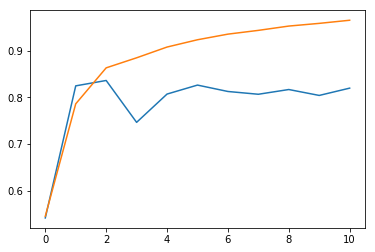

In [13]:
plt.plot(val_accs)
plt.plot(trn_accs)

In [14]:
run_epoch(clf, loss, test, training=False)

100%|██████████| 196/196 [00:13<00:00, 14.86it/s]


(0.8136718750608211, -0.7970627111439802, 13.195263624191284)